# Paso 0. Preparación de los datos continuos

Este código interactivo tiene como propósito preparar los datos requeridos para utilizar el software FMF para poder detectar microsismicidad. Vamos a requeris datos continuos en formato MINISEED además de los archivos con las respuestas intrumentales de las estaciones (archivos XML) que registraron los datos sísmicos continuos.

In [22]:
# Debemos importar todos los paquetes que se van a utilizar
import numpy as np
import obspy as obs
from obspy.geodetics.base import gps2dist_azimuth as Distance
import matplotlib.pyplot as plt
import glob
import os
import h5py as h5
from obspy import read, read_inventory
from obspy.core import UTCDateTime as udt

In [23]:
# Definimos el camino a las carpetas donde están nuestros datos sin preparar y 
# donde queremos escribir los datos una vez que estén ya preparados
#path_data = '/home/insar/Bureau/fmf_tuto_igp/tutorial/datos/'
#path_to_store_h5 = '/home/insar/Bureau/datos/preparados/'
#path_data = '/home/insar/Bureau/fmf_tuto_igp/tutorial/datos/'
#path_to_store_h5 = '/home/insar/Bureau/datos/preparados/'

path_data = '/home/sanchezh/Public/fmf_tuto_igp/tutorial/datos/'
path_to_store_h5 = '/home/sanchezh/datos/preparados/'

In [24]:
# Datos de la red y lista de estaciones y componentes a utilizar
network = 'PE'
stations = ['LAGN']#,'CGLO','CHVY','QLK0']
components=['BHE','BHN','BHZ'] # datos a 50 Hz, 50 muestras por segundo

# Nombre del archivo de salida
name_of_splitted_data_file = 'waveforms_'

# Fecha de referencia. Ocuparemos el primer día del año 2022
# ya que nuestros archivos están referenciados a ese dia
# PE.CHVY..BHZ.D.2022.146   = día 146 del año 2022 = 26 de Mayo de 2022

# Fecha de referencia
start_date = udt('2022-01-01T00:00:00')
start_time_first_day = udt('2022-01-01T00:00:00')

# Crear lista de días con los que vamos a trabajar
days = np.linspace(146,147,1) # on my computer
print('Lista de los días que se van a procesar: ', days)


Lista de los días que se van a procesar:  [146.]


## Parámetros de preprocesado de los datos

En el siguiente bloque se deben definir las frequencias con las cuales se desea trabajar. Para una mejor detección de los eventos sísmicos utilizaremos en este caso un filtro pasabandas que permite el paso de frecuencias entre 0.05 y 22 Hz.

In [25]:
# Definimos las frecuencias de corte de nuestro filtro a utilizar
pre_filt = (.01,.05,22,24)
bandpass = 'bandpass'
bandpass_fmin = 5.0
bandpass_fmax = 20.0

## Preparación de los datos continuos

In [26]:
# Borrar todos los datos en la carpeta de salida
# para tener un directorio limpio antes de correr el código
#os.system('rm /home/insar/datos/preparados/*')
os.system('rm /home/sanchezh/datos/preparados/*')

print('=======================================================')
print('Espere por favor, este proceso puede tomar unos minutos')
print('=======================================================')

# Ciclo "for" para preparar cada dia de la lista de días a analizar
for k in range(len(days)):
    # inicio de la fecha de preparación
    start_time_splitted_data = start_time_first_day+86400*(days[k]-1)
    print('Datos en preparación para la fecha: ', start_time_splitted_data)
    # fina de la fecha de preparación
    end_time_splitted_data = start_time_first_day+(86400*(days[k]))
    # fecha de inicio de los datos (cuenta en segundos)
    start_time_splitted_data_in_s = [start_time_splitted_data - start_date]
    # Definición del archivo de salida
    template = h5.File((path_to_store_h5+name_of_splitted_data_file+start_time_splitted_data.strftime('%Y-%m-%d')+'.hdf5'), 'w')
    # Ciclo "for" sobre cada una de las estaciones a analizar
    for i in range(len(stations)):
        print('Trabajando con la estación: ', stations[i])
        # Ciclo "for" sobre cada una de las componentes a analizar
        for j in range(len(components)):
            # Definición del archivo de datos input a leer
            name_file_data = path_data + network + '.' + stations[i] + '..' + components[j] + '.D.2022.' + str(int(days[k])).zfill(3)  
            print('Preparando archivo de salida: ', name_file_data)
            # Definición del archivo con los datos de la estación
            name_file_info_station = path_data + network + '.' + stations[i] + '.xml'
            # Leer datos sísmicos del archivo de input
            st = read(name_file_data)
            print(st[0].stats.npts)
            # Leer los datos de la estación sísmica
            inv = read_inventory(name_file_info_station)
            # Rellenar con ceros 0s los momentos donde la estación no funciona
            st.trim(start_time_splitted_data, end_time_splitted_data, nearest_sample=True, pad=True, fill_value=0)
            # Remover la respuesta instrumental de la estación a los datos sísmicos
            st.remove_response(inventory=inv, pre_filt=pre_filt, plot=False)
            # Filtrar los datos en un dado rango de frecuencias para un mejor analisis
            st.filter(bandpass, freqmin=bandpass_fmin, freqmax=bandpass_fmax, zerophase=True)
            # Guardar los datos en un arreglo temporal que guarda todas las estaciones y componentes
            if i==0 and j==0:
                    data_of_station = np.zeros((len(stations), len(components), st[0].stats.npts))
                    # incrementar la amplitud por motivos computacionales
                    data_of_station[i,j,:] = st[0].data * 100000.
            else:
                # incrementar la amplitud por motivos computacionales
                data_of_station[i,j,:] = st[0].data * 100000.
        # En la última iteración de los ciclos, guarda el archivo de salida con todo listo
        if i==len(stations)-1:
            template.create_dataset('waveforms', data=data_of_station)
            template.create_dataset('stations', data=np.array((stations), dtype='|S8'))
            template.create_dataset('components', data=np.array(components, dtype='|S8'))
            template.create_dataset('date', data=np.asarray(start_time_splitted_data_in_s))
            template.create_dataset('sampling_rate', data=st[0].stats.sampling_rate)
    template.close()
print('=======================================================')
print('           Fin de la preparación de archivos           ')
print('=======================================================')


Espere por favor, este proceso puede tomar unos minutos
Datos en preparación para la fecha:  2022-05-26T00:00:00.000000Z
Trabajando con la estación:  LAGN
Preparando archivo de salida:  /home/sanchezh/Public/fmf_tuto_igp/tutorial/datos/PE.LAGN..BHE.D.2022.146
4320000
Preparando archivo de salida:  /home/sanchezh/Public/fmf_tuto_igp/tutorial/datos/PE.LAGN..BHN.D.2022.146
4320000
Preparando archivo de salida:  /home/sanchezh/Public/fmf_tuto_igp/tutorial/datos/PE.LAGN..BHZ.D.2022.146
4320000
           Fin de la preparación de archivos           


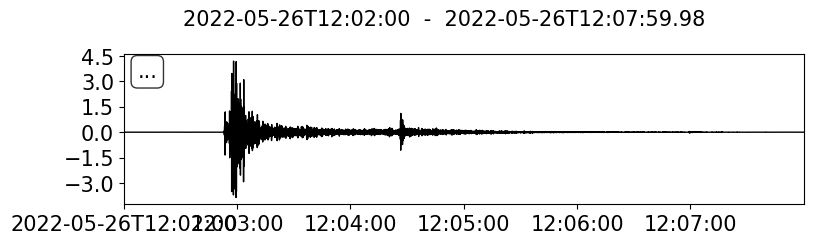

In [35]:
si = 12*60*60*50 + 2*60*50
sf = si + 6*60*50

font = {'family' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

start = udt('2022-05-26T12:02:00.0')

ref = udt('2022-05-26T12:02:0.00').timestamp
st = obs.Trace(data_of_station[0][2][si:sf])
st.stats.starttime = st.stats.starttime + ref
st.stats.sampling_rate = 50
#st.plot(starttime=start, endtime=end, outfile='ea.png', fontsize=25)
st.plot(outfile='a.png')

In [33]:
st.stats.sampling_rate

1.0